# **Online Retail Customer Segmentation Analysis**
Overview :
Online retail is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

 Goal:
We aim to segement the Customers based on RFM so that the company can target its customers efficiently.

Step 1 : Reading and Understanding Data

In [ ]:
# import required libraries for dataframe and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [ ]:
# Reading the data on which analysis needs to be done
retail = pd.read_csv('OnlineRetail.csv',encoding='unicode_escape')
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [ ]:
# shape of df
retail.shape

(259676, 8)

In [ ]:
# df info
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259676 entries, 0 to 259675
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    259676 non-null  object 
 1   StockCode    259676 non-null  object 
 2   Description  258721 non-null  object 
 3   Quantity     259676 non-null  int64  
 4   InvoiceDate  259676 non-null  object 
 5   UnitPrice    259675 non-null  float64
 6   CustomerID   185436 non-null  float64
 7   Country      259675 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 15.8+ MB


In [ ]:
# df description
retail.describe()

,Quantity,UnitPrice,CustomerID
count,259676.000000,259675.000000,185436.000000
mean,9.283534,5.016704,15289.978791
std,214.681212,115.428263,1729.503007
min,-74215.000000,0.000000,12346.000000
25%,1.000000,1.250000,13854.000000
50%,3.000000,2.100000,15159.000000
75%,10.000000,4.150000,16843.000000
max,74215.000000,38970.000000,18287.000000


Step 2 : Data Cleansing

In [ ]:
# Calculating the Missing Values % contribution in DF
df_null = round(100*(retail.isnull().sum())/len(retail), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.37
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     28.59
Country         0.00
dtype: float64

In [ ]:
# Droping rows having missing values
retail = retail.dropna()
retail.shape

(185436, 8)

In [ ]:
# Changing the datatype of Customer Id as per Business understanding
retail['CustomerID'] = retail['CustomerID'].astype(str)

Step 3 : Data Preparation

We are going to analysis the Customers based on below 3 factors:

R (Recency): Number of days since last purchase

F (Frequency): Number of tracsactions

M (Monetary): Total amount of transactions (revenue contributed)

In [ ]:
# New Attribute : Monetary
retail['Amount'] = retail['Quantity']*retail['UnitPrice']
rfm_m = retail.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,2205.95
2,12348.0,1487.24
3,12350.0,334.40
4,12352.0,601.18


In [ ]:
# New Attribute : Frequency
rfm_f = retail.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,102
2,12348.0,28
3,12350.0,17
4,12352.0,48


In [ ]:
# Merging the two dfs
rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,2205.95,102
2,12348.0,1487.24,28
3,12350.0,334.40,17
4,12352.0,601.18,48


In [ ]:
# New Attribute : Recency
# Convert to datetime to proper datatype
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d-%m-%Y %H:%M')

In [ ]:
# Compute the maximum date to know the last transaction date
max_date = max(retail['InvoiceDate'])
max_date

Timestamp('2011-07-12 09:10:00')

In [ ]:
# Compute the difference between max date and transaction date
retail['Diff'] = max_date - retail['InvoiceDate']
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,223 days 00:44:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,223 days 00:44:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,223 days 00:44:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,223 days 00:44:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,223 days 00:44:00


In [ ]:
# Compute last transaction date to get the recency of customers
rfm_p = retail.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,CustomerID,Diff
0,12346.0,174 days 22:53:00
1,12347.0,32 days 20:09:00
2,12348.0,97 days 22:23:00
3,12350.0,159 days 17:09:00
4,12352.0,111 days 17:02:00


In [ ]:
# Extract number of days only
rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,CustomerID,Diff
0,12346.0,174
1,12347.0,32
2,12348.0,97
3,12350.0,159
4,12352.0,111


In [ ]:
# Merge tha dataframes to get the final RFM dataframe
rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,174
1,12347.0,2205.95,102,32
2,12348.0,1487.24,28,97
3,12350.0,334.40,17,159
4,12352.0,601.18,48,111


There are 2 types of outliers and we will treat outliers as it can skew our dataset


*   Statistical
*   Domain Specific




Text(0.5, 0, 'Attributes')

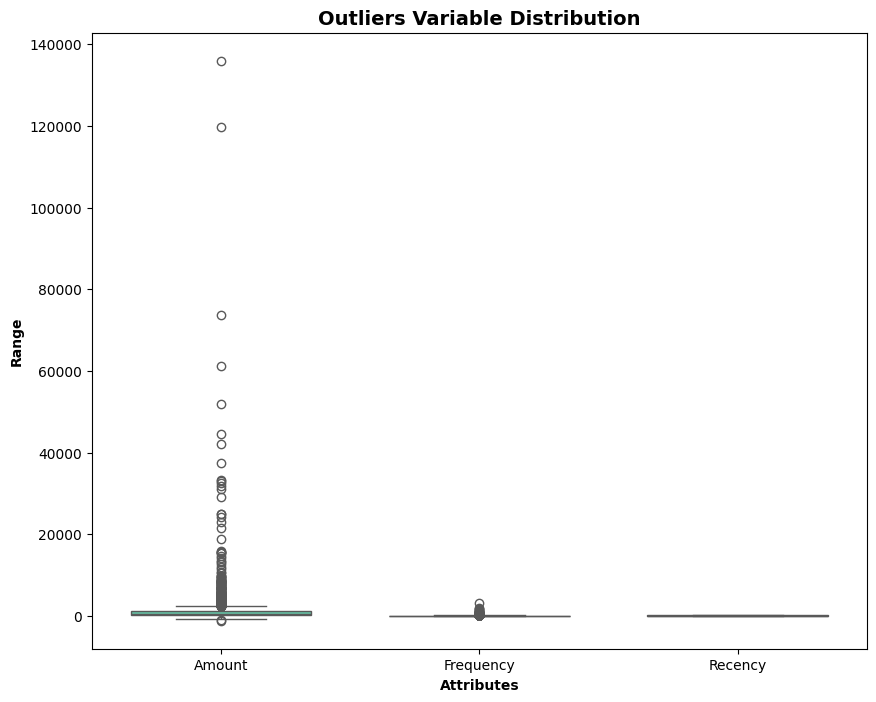

In [ ]:
# Outlier Analysis of Amount Frequency and Recency

attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [ ]:
# Removing (statistical) outliers for Amount
Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]
# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

Rescaling the Attributes:

It is extremely important to rescale the variables so that they have a comparable scale. There are two common ways of rescaling:


*   Min-Max Scaling
*   Standardisation

Here, we will use Standardisation Scaling.

In [ ]:
# Rescaling the attributes
rfm_df = rfm[['Amount', 'Frequency', 'Recency']]
# Instantiate
scaler = StandardScaler()
# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(3011, 3)

In [ ]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()


,Amount,Frequency,Recency
0,-0.742797,-0.790099,1.543606
1,1.065724,0.771163,-0.691487
2,0.476499,-0.384171,0.331619
3,-0.468643,-0.555910,1.307504
4,-0.249926,-0.071919,0.551980


Step 4 : Building the Model

K-Means Clustering

K-means clustering is one of the simplest and popular unsupervised machine learning algorithms.

The algorithm works as follows:


*   First we initialize k points, called means, randomly.
*  We categorize each item to its closest mean and we update the mean’s coordinates, which are the averages of the items categorized in that mean so far.
*  We repeat the process for a given number of iterations and at the end, we have our clusters.

In [ ]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=50, n_clusters=4)

In [ ]:
kmeans.labels_

array([2, 0, 3, ..., 3, 1, 3], dtype=int32)

**Finding the Optimal Number of Clusters**

*Elbow Curve to get the right number of Clusters*

A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

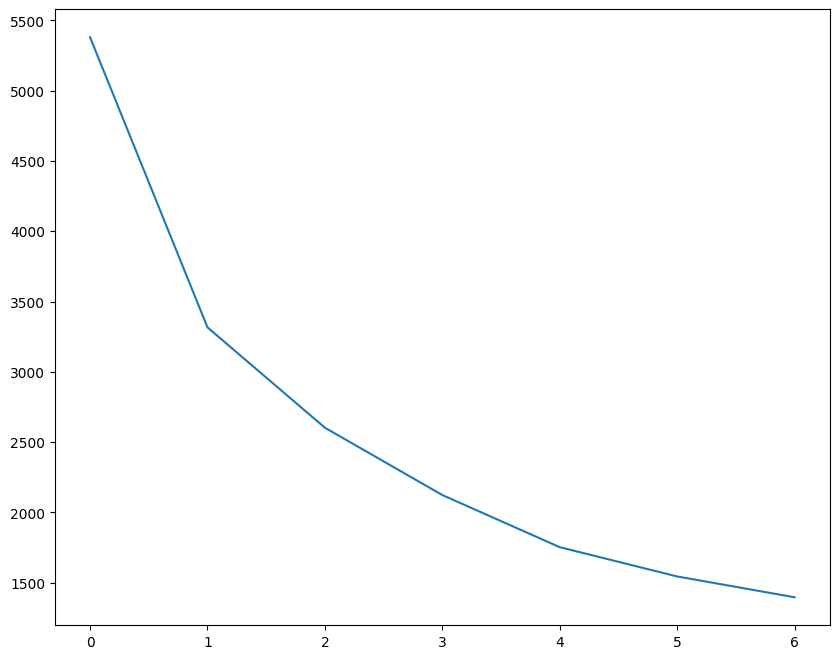

In [ ]:
# Elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)

    ssd.append(kmeans.inertia_)
# plot the SSDs for each n_clusters
plt.plot(ssd)

**Silhouette Analysis**

silhouette score= p-q/max(p,q)
where,

p
  is the mean distance to the points in the nearest cluster that the data point is not a part of

q
  is the mean intra-cluster distance to all the points in its own cluster.


*   The value of the silhouette score range lies between -1 to 1.
*   A score closer to 1 indicates that the data point is very similar to other data points in the cluster
*  A score closer to -1 indicates that the data point is not similar to the data points in its cluster



In [ ]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:

    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)

    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=2, the silhouette score is 0.5374182746734117
For n_clusters=3, the silhouette score is 0.4409219228272552


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=4, the silhouette score is 0.42225139372725745


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=5, the silhouette score is 0.4084192425590451


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=6, the silhouette score is 0.38422458358225425


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=7, the silhouette score is 0.3791455388484092


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=8, the silhouette score is 0.3604891324754942


In [ ]:
# Final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=50, n_clusters=3)

In [ ]:
 kmeans.labels_

array([2, 0, 0, ..., 0, 1, 0], dtype=int32)

In [ ]:
# assign the label
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,12346.0,0.00,2,174,2
1,12347.0,2205.95,102,32,0
2,12348.0,1487.24,28,97,0
3,12350.0,334.40,17,159,2
4,12352.0,601.18,48,111,2


<Axes: xlabel='Cluster_Id', ylabel='Amount'>

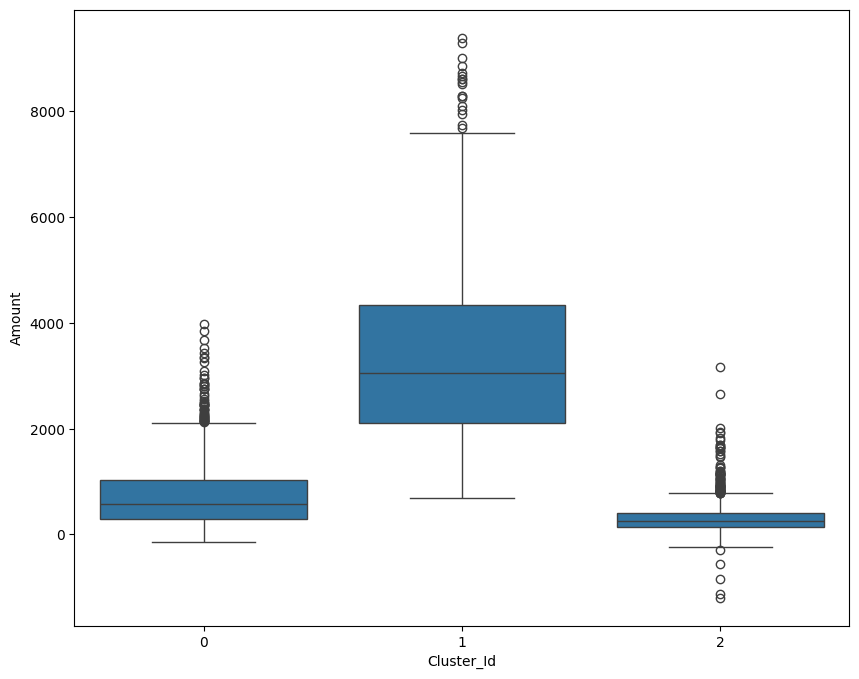

In [ ]:
# Box plot to visualize Cluster Id vs Frequency
sns.boxplot(x='Cluster_Id', y='Amount', data=rfm)

<Axes: xlabel='Cluster_Id', ylabel='Frequency'>

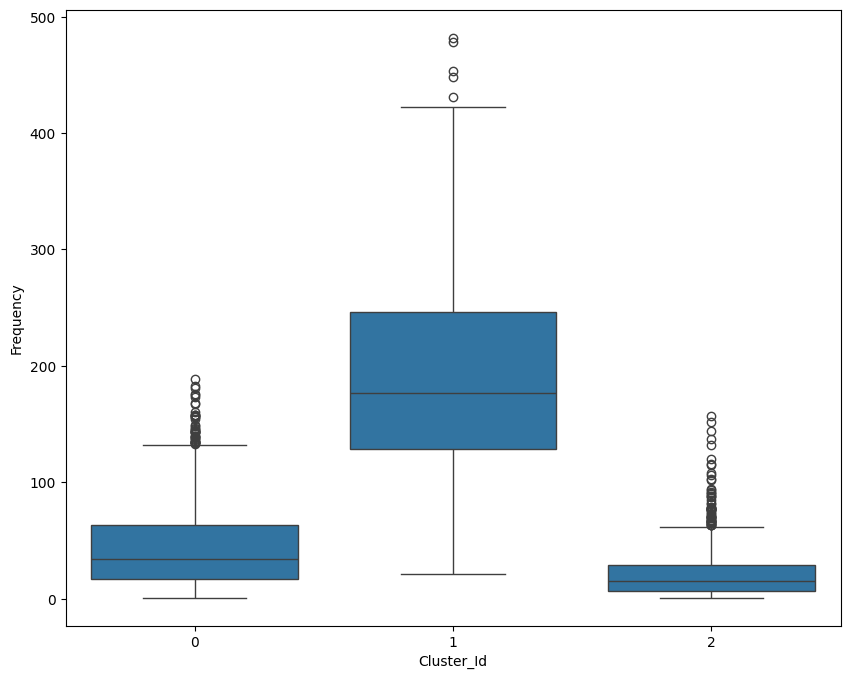

In [ ]:
# Box plot to visualize Cluster Id vs Frequency
sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

<Axes: xlabel='Cluster_Id', ylabel='Recency'>

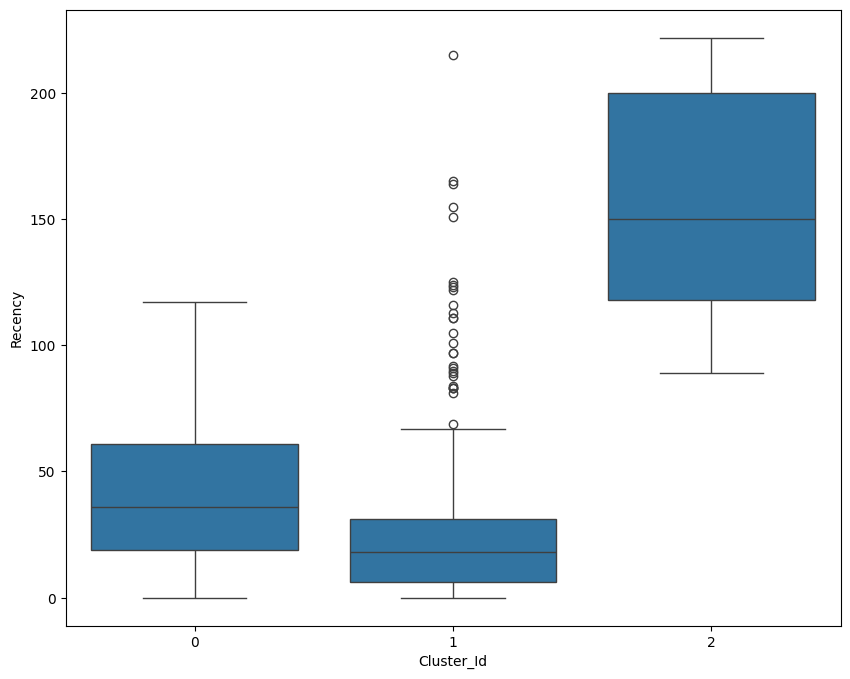

In [ ]:
# Box plot to visualize Cluster Id vs Recency
sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)

***Hierarchical Clustering***

Hierarchical clustering involves creating clusters that have a predetermined ordering from top to bottom

Single Linkage:

In single linkage hierarchical clustering, the distance between two clusters is defined as the shortest distance between two points in each cluster.

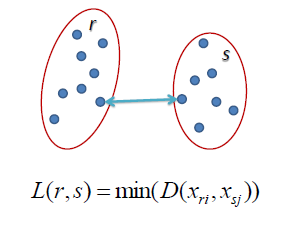

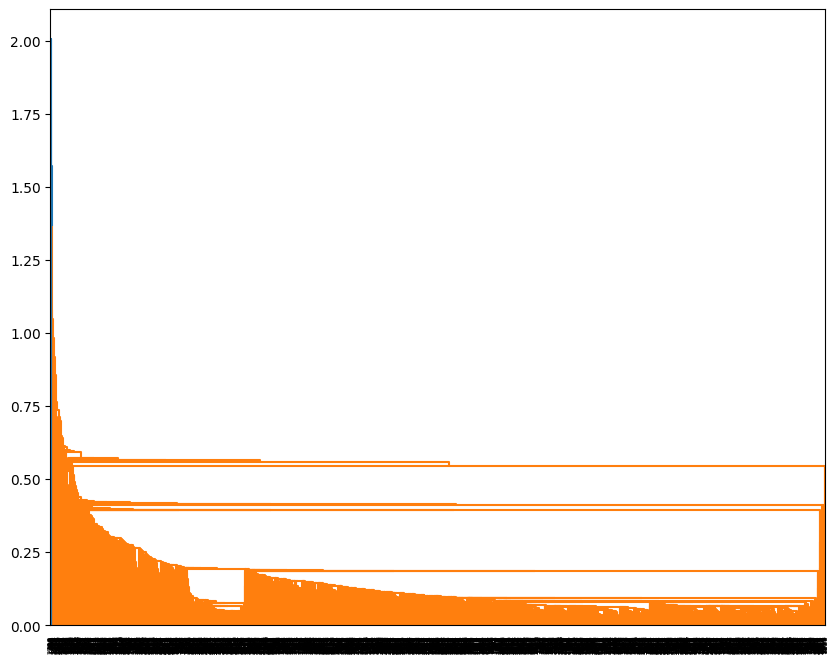

In [ ]:
# Single linkage:
mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

Complete Linkage

In complete linkage hierarchical clustering, the distance between two clusters is defined as the longest distance between two points in each cluster.

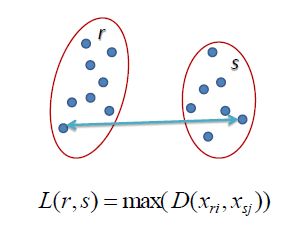

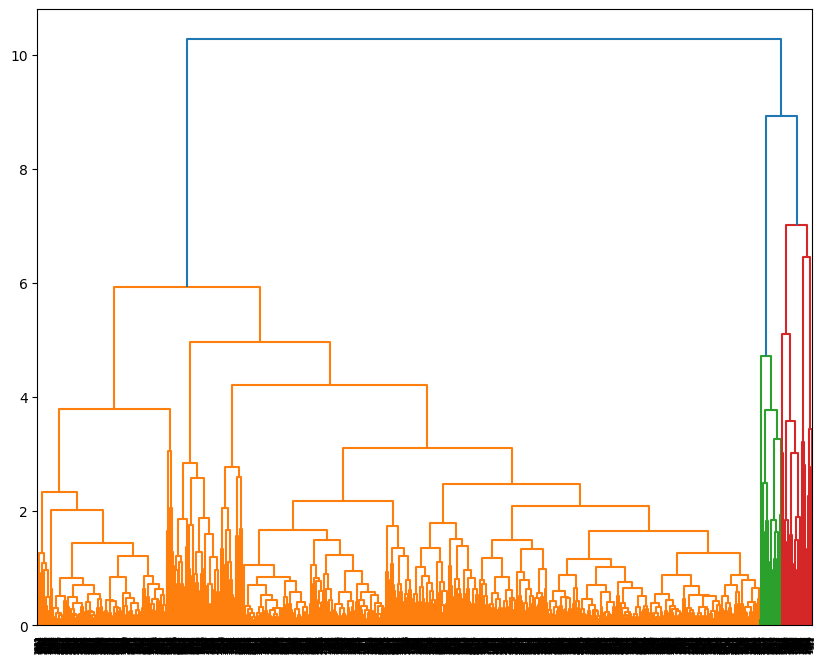

In [ ]:
# Complete linkage
mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

Average Linkage:

In average linkage hierarchical clustering, the distance between two clusters is defined as the average distance between each point in one cluster to every point in the other cluster.

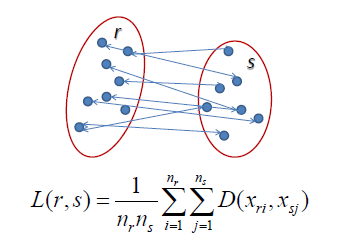

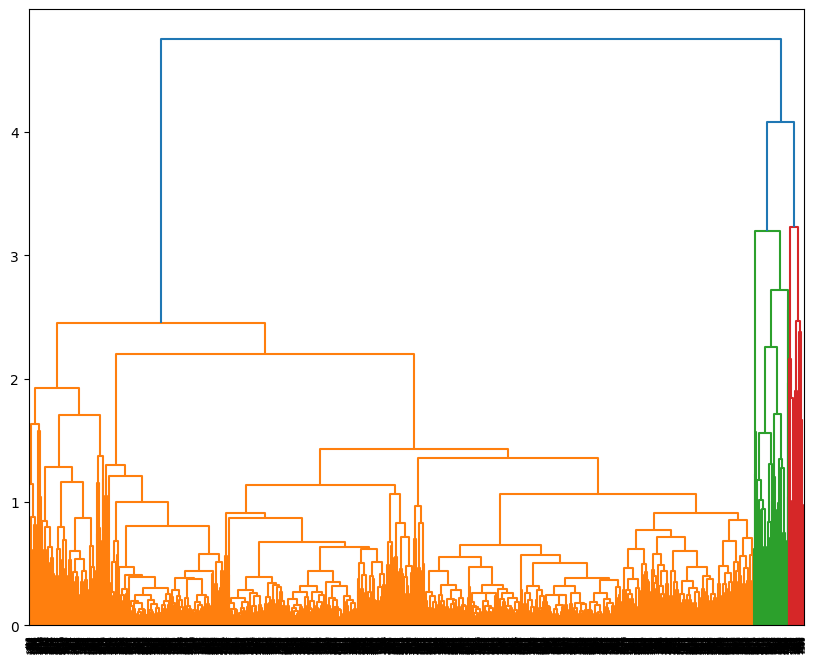

In [ ]:
# Average linkage
mergings = linkage(rfm_df_scaled, method="average", metric='euclidean')
dendrogram(mergings)
plt.show()

Cutting the Dendrogram based on k

In [ ]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, ..., 0, 2, 0])

In [ ]:
# Assign cluster labels
rfm['Cluster_Labels'] = cluster_labels
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id,Cluster_Labels
0,12346.0,0.00,2,174,2,0
1,12347.0,2205.95,102,32,0,0
2,12348.0,1487.24,28,97,0,0
3,12350.0,334.40,17,159,2,0
4,12352.0,601.18,48,111,2,0


<Axes: xlabel='Cluster_Labels', ylabel='Amount'>

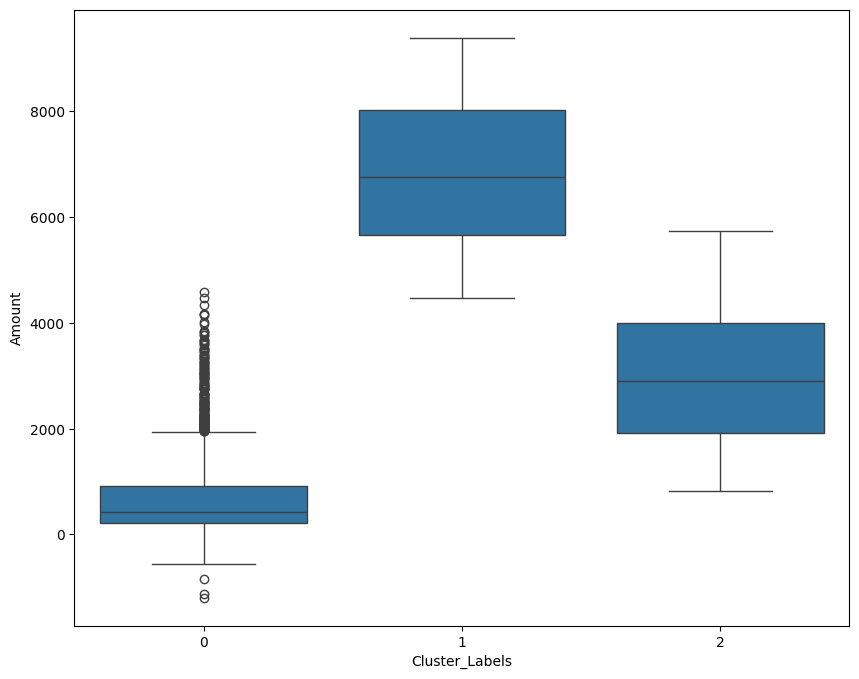

In [ ]:
# Plot Cluster Id vs Amount
sns.boxplot(x='Cluster_Labels', y='Amount', data=rfm)

<Axes: xlabel='Cluster_Labels', ylabel='Frequency'>

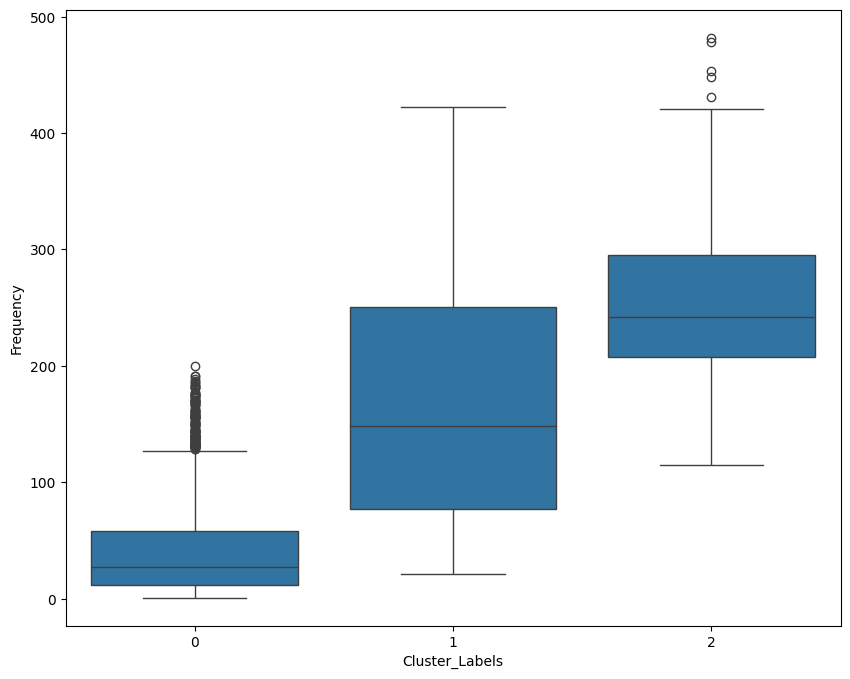

In [ ]:
# Plot Cluster Id vs Frequency
sns.boxplot(x='Cluster_Labels', y='Frequency', data=rfm)

<Axes: xlabel='Cluster_Labels', ylabel='Recency'>

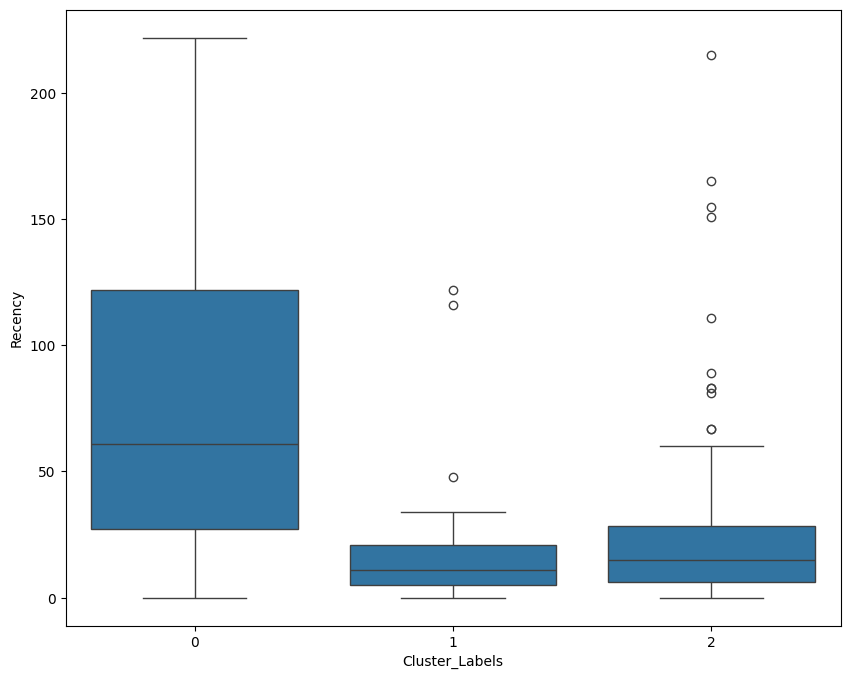

In [ ]:
# Plot Cluster Id vs Recency
sns.boxplot(x='Cluster_Labels', y='Recency', data=rfm)

Step 5 : Final Analysis

Inference:

K-Means Clustering with 3 Cluster Ids


*   Customers with Cluster Id 1 are the customers with
high amount of transactions as compared to other customers.
*   Customers with Cluster Id 1 are frequent buyers.
*   Customers with Cluster Id 2 are not recent buyers and hence least of importance from business point of view.

Hierarchical Clustering with 3 Cluster Labels


*   Customers with Cluster_Labels 2 are the customers with high amount of transactions as compared to other customers.
*   Customers with Cluster_Labels 2 are frequent buyers
*   Customers with Cluster_Labels 0 are not recent buyers and hence least of importance from business point of view.